In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('Electric_Production.csv')

In [3]:
df['DATE']=pd.to_datetime(df['DATE'])

In [4]:
df.rename(columns={'IPG2211A2N':'Output'},inplace=True)

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
df.set_index('DATE',inplace=True)

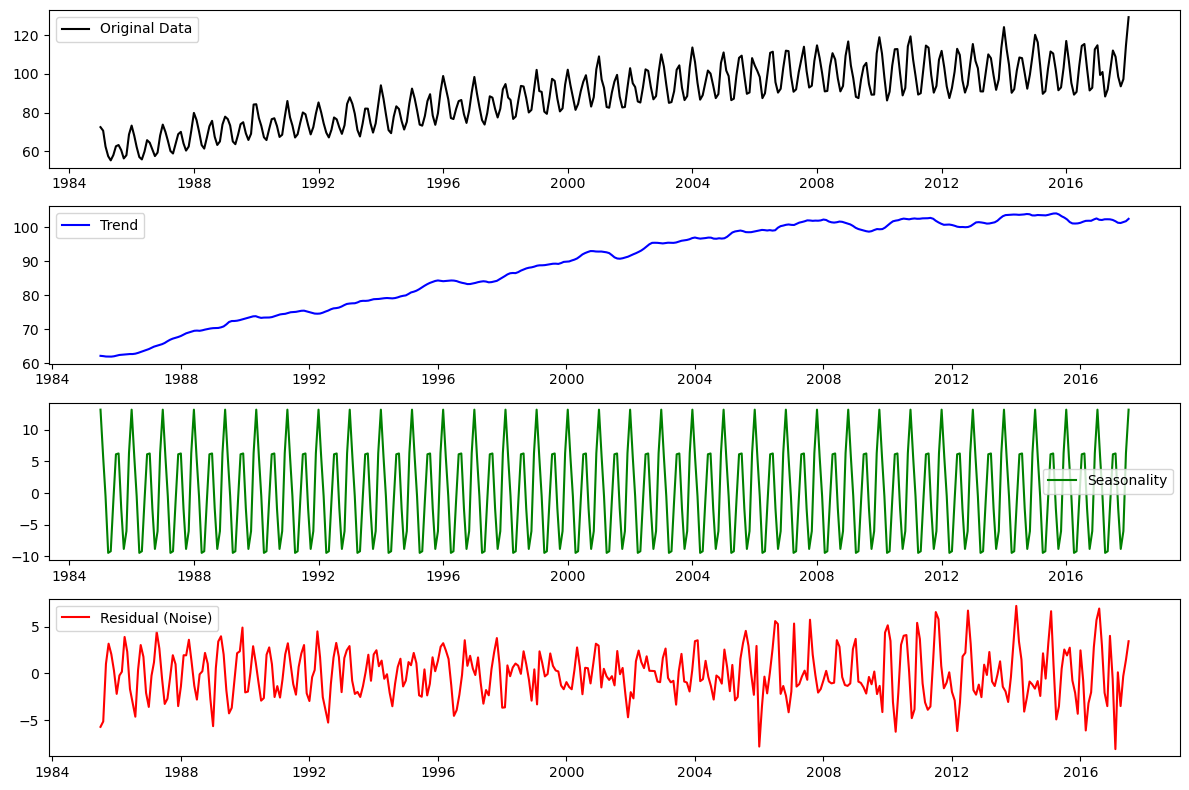

In [7]:
result=seasonal_decompose(df['Output'], model='additive', period=12)

# Plot components

plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(df['Output'], label="Original Data", color="black") 
plt.legend()

plt.subplot(4,1,2)
plt.plot(result.trend, label="Trend", color="blue") 
plt.legend()

plt.subplot(4,1,3)
plt.plot(result.seasonal, label="Seasonality", color="green") 
plt.legend()

plt.subplot (4,1,4)
plt.plot(result.resid, label="Residual (Noise)", color="red")
plt.legend()
plt.tight_layout()

plt.show()

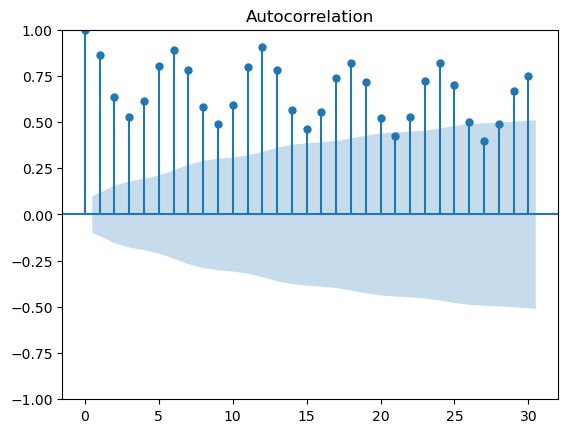

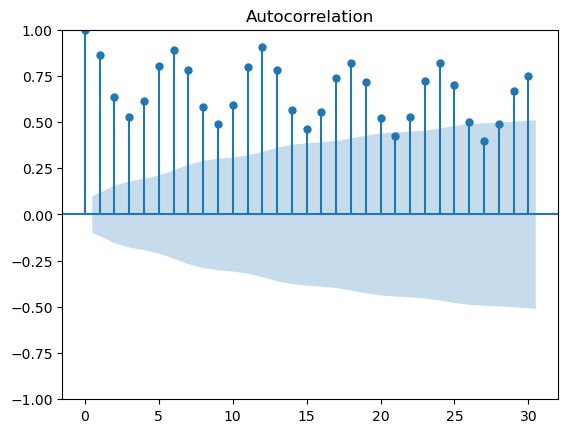

In [8]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['Output'],lags=30,ax=plt.gca())

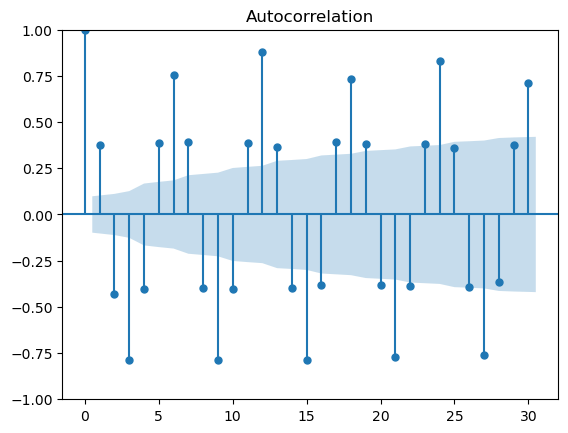

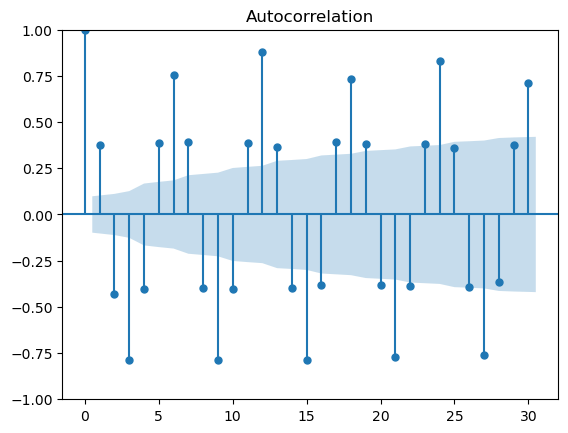

In [9]:
df_diff1 = df.diff().dropna()
plot_acf(df_diff1,lags=30,ax=plt.gca())

Text(0.5, 1.0, 'PACF - Electricity Output')

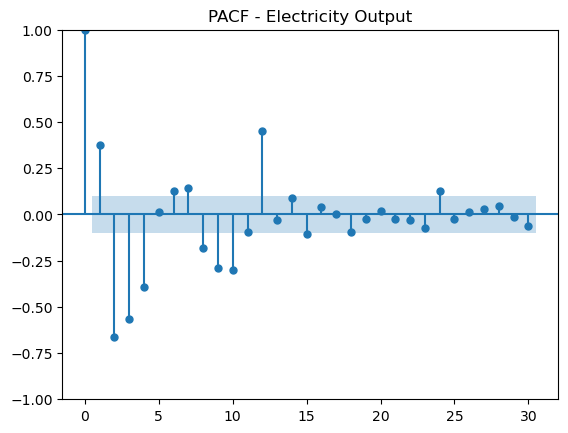

In [10]:
plot_pacf(df_diff1, lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF - Electricity Output')

In [11]:
df_diff2 = df_diff1.diff().dropna()

Text(0.5, 1.0, 'PACF - Electricity Output')

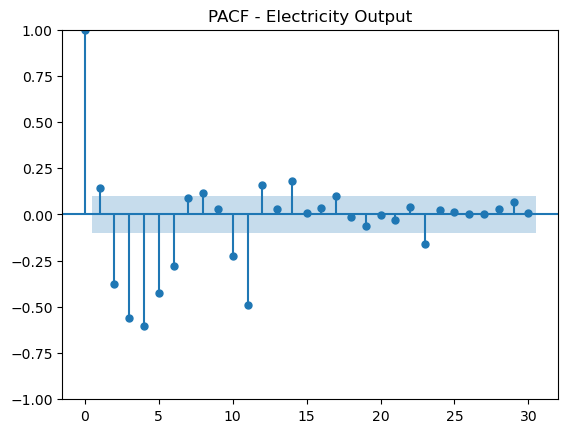

In [12]:
plot_pacf(df_diff2, lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF - Electricity Output')

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
adf_result_original = adfuller(df_diff2)

In [21]:
adf_result_original

(-9.863042323279315,
 4.1836937479974466e-17,
 17,
 377,
 {'1%': -3.4478152097574224,
  '5%': -2.8692371153451903,
  '10%': -2.5708704003405356},
 1873.1465222910638)

In [22]:
adf_result_diff1 = adfuller(df_diff1)

In [23]:
adf_result_diff1

(-7.104890882267298,
 4.077786565539737e-10,
 14,
 381,
 {'1%': -3.4476305904172904,
  '5%': -2.869155980820355,
  '10%': -2.570827146203181},
 1840.5415092614141)

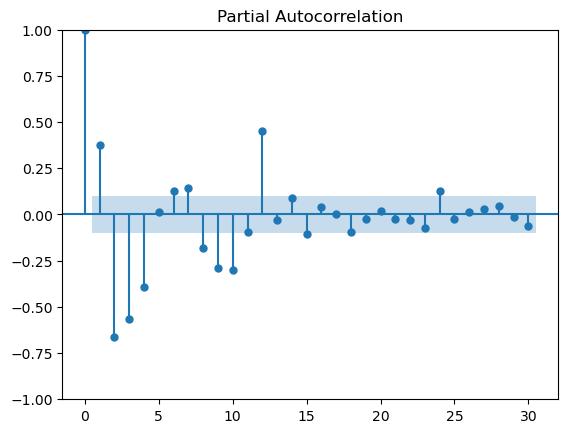

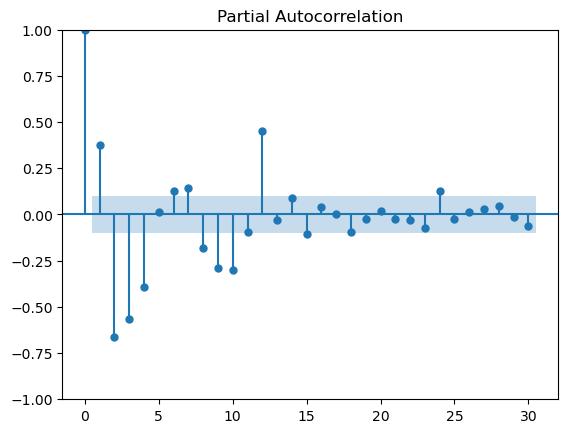

In [24]:
plot_pacf(df_diff1, lags=30, ax=plt.gca(), method='ywm')

In [22]:
train=df.iloc[:-24]
test=df.iloc[-24:]

In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model=SARIMAX(train['Output'],order=(3,1,3),seasonal_order=(1,1,1,12))
model_fit=sarima_model.fit()
model_forecast=model_fit.forecast(24)

C:\Users\badhr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\badhr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\badhr\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test, model_forecast)
rmse = np.sqrt(mean_squared_error(test, model_forecast))

In [93]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 3.15
RMSE: 4.23


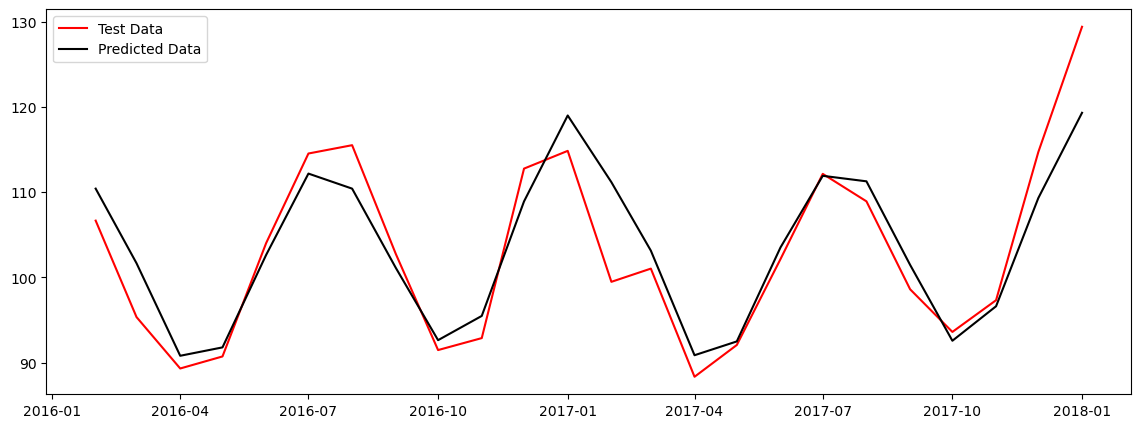

In [123]:
plt.figure(figsize=(14, 5))
plt.plot(test.index,test.values,color='red',label='Test Data')
plt.plot(test.index,model_forecast.values,color='black',label='Predicted Data')
plt.legend()


In [101]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
holts_model=ExponentialSmoothing(train['Output'],trend='add',seasonal='add',seasonal_periods=12)
model_fit1=holts_model.fit()
holts_forecast=model_fit1.forecast(24)

C:\Users\badhr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [113]:
mae = mean_absolute_error(test, holts_forecast)
rmse = np.sqrt(mean_squared_error(test, holts_forecast))

In [103]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 3.27
RMSE: 4.23


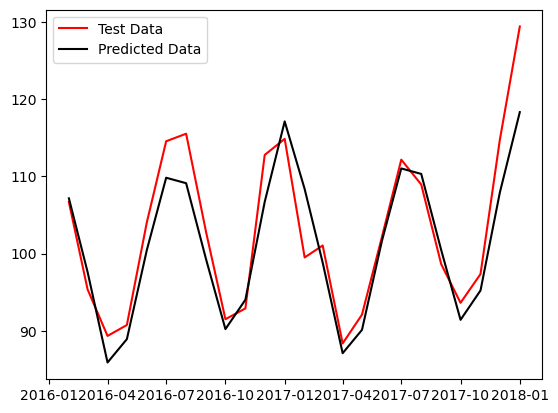

In [104]:
plt.plot(test.index,test.values,color='red',label='Test Data')
plt.plot(test.index,holts_forecast.values,color='black',label='Predicted Data')
plt.legend()

In [105]:
from sklearn.linear_model import LinearRegression
Stack= np.vstack([model_forecast,holts_forecast]).T
y_test=test['Output'].values
Linear=LinearRegression()
Linear.fit(Stack,y_test)
forecast_linear=Linear.predict(Stack)

In [108]:
mae = mean_absolute_error(test,forecast_linear)
rmse = np.sqrt(mean_squared_error(test,forecast_linear))

In [109]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2.86
RMSE: 3.78


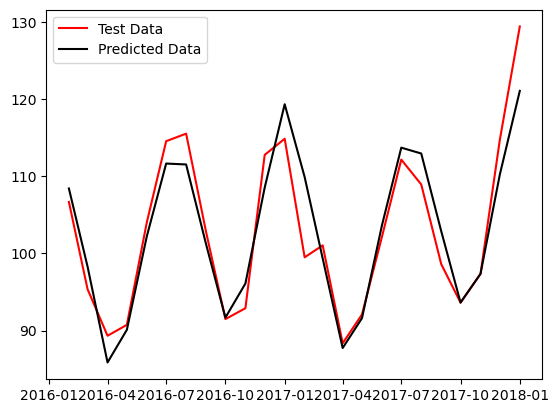

In [111]:
plt.plot(test.index,test.values,color='red',label='Test Data')
plt.plot(test.index,forecast_linear,color='black',label='Predicted Data')
plt.legend()

In [125]:
future_sarimax= model_fit.forecast(steps=6)
future_holts= model_fit1.forecast(6)
future_stack = np.vstack([future_sarimax, future_holts]).T
future_linear_forecast = Linear.predict(future_stack)


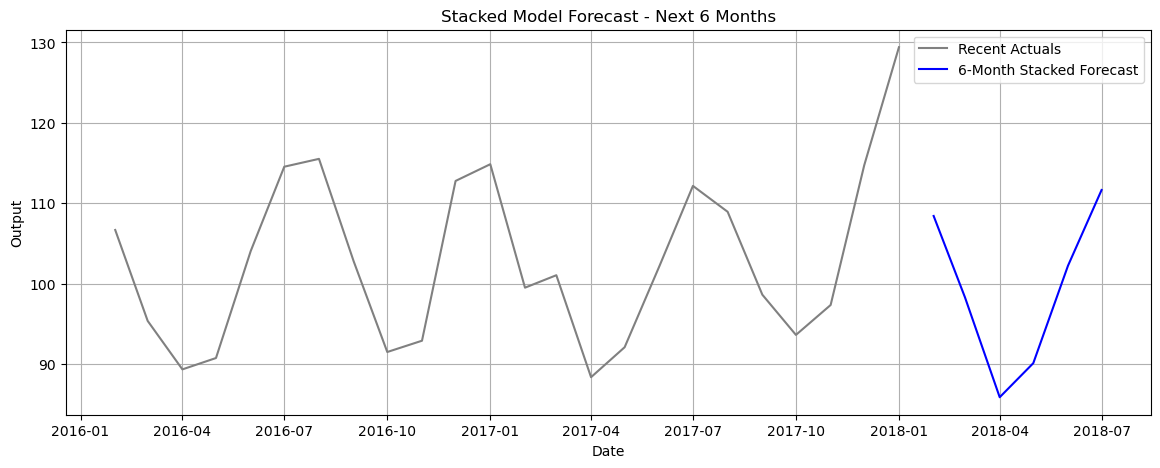

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')

# Plot
plt.figure(figsize=(14, 5))
plt.plot(df.index[-24:], df['Output'].values[-24:], label='Recent Actuals', color='gray')
plt.plot(future_dates, future_linear_forecast, label='6-Month Stacked Forecast', color='blue')
plt.legend()
plt.title("Stacked Model Forecast - Next 6 Months")
plt.xlabel("Date")
plt.ylabel("Output")
plt.grid(True)
plt.show()


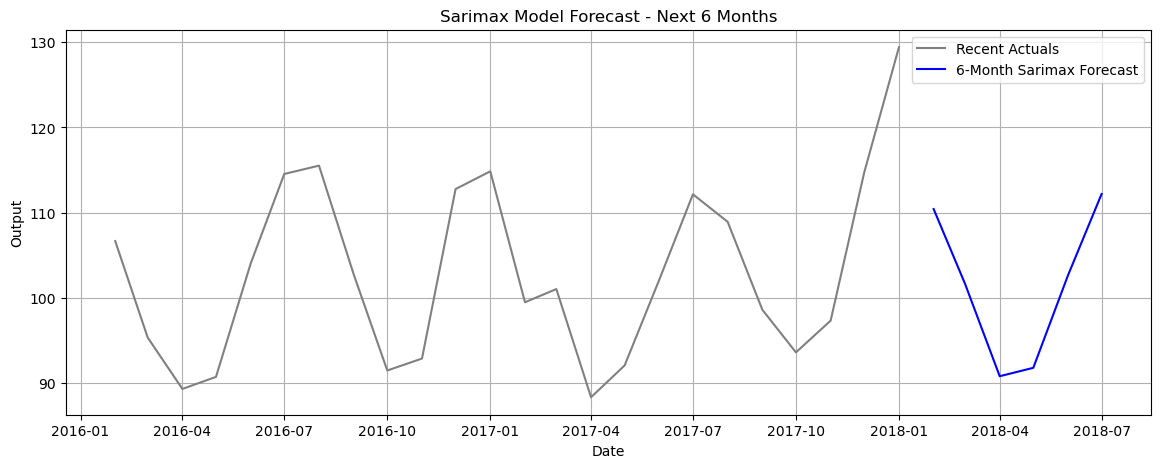

In [130]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')

# Plot
plt.figure(figsize=(14, 5))
plt.plot(df.index[-24:], df['Output'].values[-24:], label='Recent Actuals', color='gray')
plt.plot(future_dates,future_sarimax , label='6-Month Sarimax Forecast', color='blue')
plt.legend()
plt.title("Sarimax Model Forecast - Next 6 Months")
plt.xlabel("Date")
plt.ylabel("Output")
plt.grid(True)
plt.show()

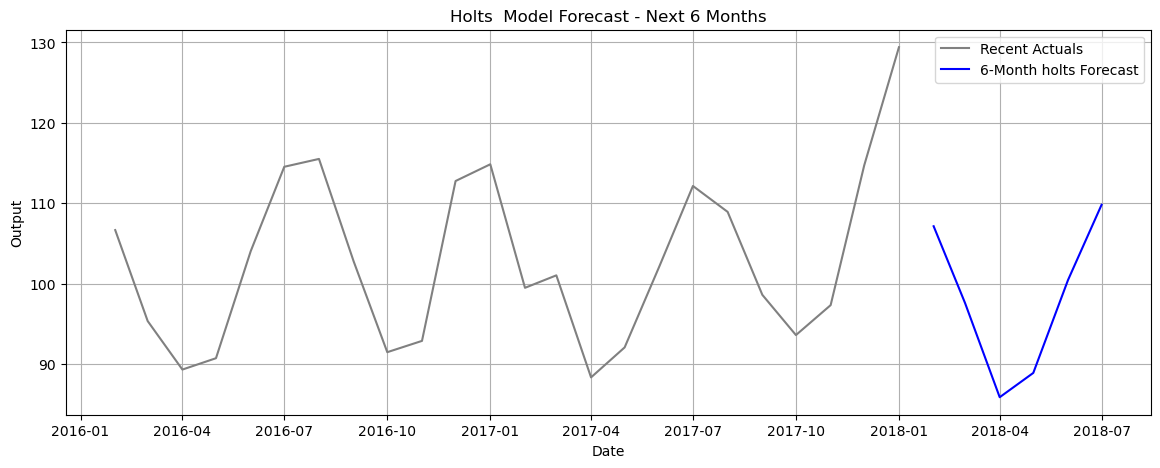

In [129]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')

# Plot
plt.figure(figsize=(14, 5))
plt.plot(df.index[-24:], df['Output'].values[-24:], label='Recent Actuals', color='gray')
plt.plot(future_dates,future_holts , label='6-Month holts Forecast', color='blue')
plt.legend()
plt.title("Holts  Model Forecast - Next 6 Months")
plt.xlabel("Date")
plt.ylabel("Output")
plt.grid(True)
plt.show()